In [2]:
import momi        ## momi2 analysis
import logging        ## create log file
import numpy as np
import datetime
import matplotlib as plt

In [3]:
print("-----\n-----\n-----")

print("start logging\n")
logging.basicConfig(level=logging.INFO,
                    filename="momi_log_redo.txt")


-----
-----
-----
start logging



In [4]:
print("load sfs\n")
## sfspath = "/home/kprovost/nas1/momi2/cardcard16_sfs_filtered_changelength_monomorphic.txt"
sfspath = "/Users/kprovost/Downloads/outfiles_allgroup/cardcard_files2/cardcard16_sfs_filtered_changelength_monomorphic.txt"
## this is a two-population sfs with monomorphic sites included in "length"
sfs = momi.Sfs.load(sfspath)
#print("Avg pairwise heterozygosity", sfs.avg_pairwise_hets[:5])
#print("populations", sfs.populations)
#print("percent missing data per population", sfs.p_missing)

load sfs



In [8]:
print("\nPRIORS")
print("MUT RATE: 2.21e-9")
print("ANCESTRAL NE: 300,000")
print("GEN TIME: 1")
print("DIV TIME RANGE: 500,000 to 2,500,000")
print("NE RANGE: 1,000 to 2,000,000")
print("MIGRATION RANGE: 0 to 0.5")
print("MIGRATION DATE RANGE: 0 to 1,000,000 [25,000 for SECC model]\n\n")


print("begin setting up models\n")
##### PURE ISOLATION MODEL #####
print("\nPure Isolation model (base model)")
pure_isolation_model = momi.DemographicModel(N_e=300000,muts_per_gen=2.21e-9,gen_time=1) ## why tho -- can you give it something?
pure_isolation_model.set_data(sfs)
## set up divergence times
pure_isolation_model.add_time_param("tdiv_sc",lower=500000,upper=2500000)
## set up effective population size
pure_isolation_model.add_size_param("ne_s",lower=1000,upper=2000000) ## this is from Brian's paper on cardinals
pure_isolation_model.add_size_param("ne_c",lower=1000,upper=2000000) 
## set up populations and phylogeny
pure_isolation_model.add_leaf("Son",N="ne_s")
pure_isolation_model.add_leaf("Chi",N="ne_c")
pure_isolation_model.move_lineages("Son", "Chi", t="tdiv_sc")
## randomize parameters and check them

pure_isolation_model.set_params(randomize=True)
print(pure_isolation_model.get_params())



PRIORS
MUT RATE: 2.21e-9
ANCESTRAL NE: 300,000
GEN TIME: 1
DIV TIME RANGE: 500,000 to 2,500,000
NE RANGE: 1,000 to 2,000,000
MIGRATION RANGE: 0 to 0.5
MIGRATION DATE RANGE: 0 to 1,000,000 [25,000 for SECC model]


begin setting up models


Pure Isolation model (base model)
ParamsDict({'tdiv_sc': 825281.8169409471, 'ne_s': 604108.3284458731, 'ne_c': 467006.51789799466})


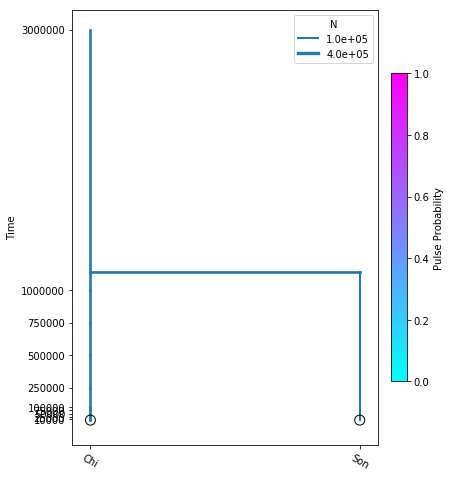

In [6]:
## check that the model is what you want 
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5,1e6,3e6]
fig = momi.DemographyPlot(
	pure_isolation_model, 
	["Chi","Son"],
	figsize=(6,8),
	major_yticks=yticks,
	#linthreshy=2.5e6
)

In [7]:
## STOCH OPT WITH SNPS
## SNPS IS FASTER?

pure_isolation_model.stochastic_optimize(num_iters=10, snps_per_minibatch=1000, save_to_checkpoint="momi_checkpoint_isol.txt", svrg_epoch=-1)
print(pure_isolation_model.get_params())



ParamsDict({'tdiv_sc': 821390.62713735, 'ne_s': 248502.76684115434, 'ne_c': 483532.3131477909})


In [9]:
## TRY STOCHASTIC OPTIMIZE
## STILL FAST BUT NOT SO FAST

pure_isolation_model.stochastic_optimize(num_iters=10, n_minibatches=5, save_to_checkpoint="momi_checkpoint_isol.txt", svrg_epoch=-1)
print(pure_isolation_model.get_params())


ParamsDict({'tdiv_sc': 1143684.9793702736, 'ne_s': 254084.13729224761, 'ne_c': 850194.6386909911})


In [ ]:
## TRY THE OPTIMIZE WITH THE OTHER MODEL FROM HERE


pure_isolation_model.optimize(method="L-BFGS-B")
print(pure_isolation_model.get_params())


In [11]:
##### ASYMMETRIC MIGRATION #####
print("\nAsymmetric model (c2s as base)")
asym_model = pure_isolation_model.copy() ## copy isol
asym_model.add_pulse_param("mig_s2c",lower=0,upper=0.1)
asym_model.add_pulse_param("mig_c2s",lower=0,upper=0.1)
asym_model.add_time_param("tmig_asym",lower=0,upper=1000000,upper_constraints=["tdiv_sc"])
asym_model.move_lineages("Chi","Son",t="tmig_asym",p="mig_s2c")
asym_model.move_lineages("Son","Chi",t="tmig_asym",p="mig_c2s")
## randomize and check parameters
#asym_model.set_params(randomize=True)
#print(asym_model.get_params())


Asymmetric model (c2s as base)


In [ ]:
models = [asym_model]
model_names = ["ASYM"]
AICs = []
count = 0
for model in models:
	now = datetime.datetime.now()
	name = str(model_names[count])
	print("Stochastic optimizing "+name+" model: "+str(now))
	model.stochastic_optimize(num_iters=10, snps_per_minibatch=1000, save_to_checkpoint="momi_checkpoint_isol.txt", svrg_epoch=-1)
	now = datetime.datetime.now()
	print("Finished stochastic optimizing "+name+": "+str(now))
	print("Fully optimizing "+name+" model: "+str(now))
	model.optimize(method="L-BFGS-B")
	now = datetime.datetime.now()
	print("Finished fully optimizing "+name+": "+str(now))
	print(model.get_params())
	print("Starting AIC likelihood for "+name)
	lik = model.log_likelihood()
	nparams = len(model.get_params())
	aic = 2*nparams - 2*lik
	print("AIC {}".format(aic))
	AICs.append(aic)
	count += 1
	print("-----")

minv = np.min(AICs)
delta_aic = np.array(AICs) - minv
print("Delta AIC per model: ", delta_aic)
print("AIC weight per model: ", np.exp(-0.5 * delta_aic))

Stochastic optimizing ASYM model: 2018-08-16 16:10:51.113576
